In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


In [3]:
# Load the cleaned data from the CSV file created in the data preparation script
hotel_data = pd.read_csv('cleaned_data.csv', parse_dates=["Date"], index_col="Date")

# Display the first few rows to verify the data has been loaded correctly
print(hotel_data.head())


            Arrivals  Occupied  OccPercent  RoomRev  RevPAR     ADR
Date                                                               
2022-10-01        40        67       90.54  7163.51   96.80  106.92
2022-10-02        23        29       38.67  2669.72   35.60   92.06
2022-10-03        22        25       34.67  2165.42   28.87   83.29
2022-10-04        23        33       43.42  2981.50   39.23   90.35
2022-10-05        29        40       52.63  3608.22   47.48   90.21


In [4]:
# Resample the data to get monthly total revenue
monthly_revenue = hotel_data['RoomRev'].resample('M').sum()

# Display the prepared data
print(monthly_revenue.head())


Date
2022-01-31     75237.21
2022-02-28     76389.29
2022-03-31    101755.05
2022-04-30     98067.38
2022-05-31    112443.46
Freq: M, Name: RoomRev, dtype: float64


<Figure size 1400x800 with 0 Axes>

/Users/amanpatel/Documents/Hospitality/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/amanpatel/Documents/Hospitality/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/amanpatel/Documents/Hospitality/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/amanpatel/Documents/Hospital

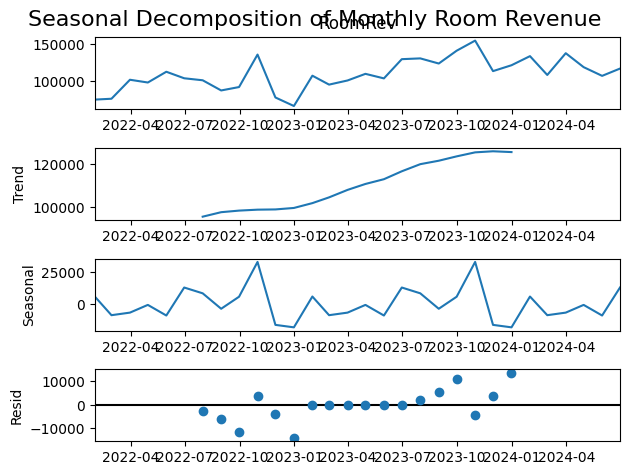

In [5]:
# Decompose the time series to analyze trend, seasonality, and residuals
decomposition = seasonal_decompose(monthly_revenue, model='additive')

# Plot the decomposition
plt.figure(figsize=(14, 8))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Monthly Room Revenue', fontsize=16)
plt.show()


In [6]:
# Define the SARIMA model
model = SARIMAX(monthly_revenue, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

# Fit the model
sarima_result = model.fit()

# Display the model summary
print(sarima_result.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42063D+00    |proj g|=  3.39038D-01

At iterate    5    f=  6.30634D+00    |proj g|=  2.85980D-02

At iterate   10    f=  6.30172D+00    |proj g|=  3.15107D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   1.144D-05   6.302D+00
  F =   6.3017143237502653     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                  

/Users/amanpatel/Documents/Hospitality/.venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


/Users/amanpatel/Documents/Hospitality/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/amanpatel/Documents/Hospitality/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/amanpatel/Documents/Hospitality/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/amanpatel/Documents/Hospital

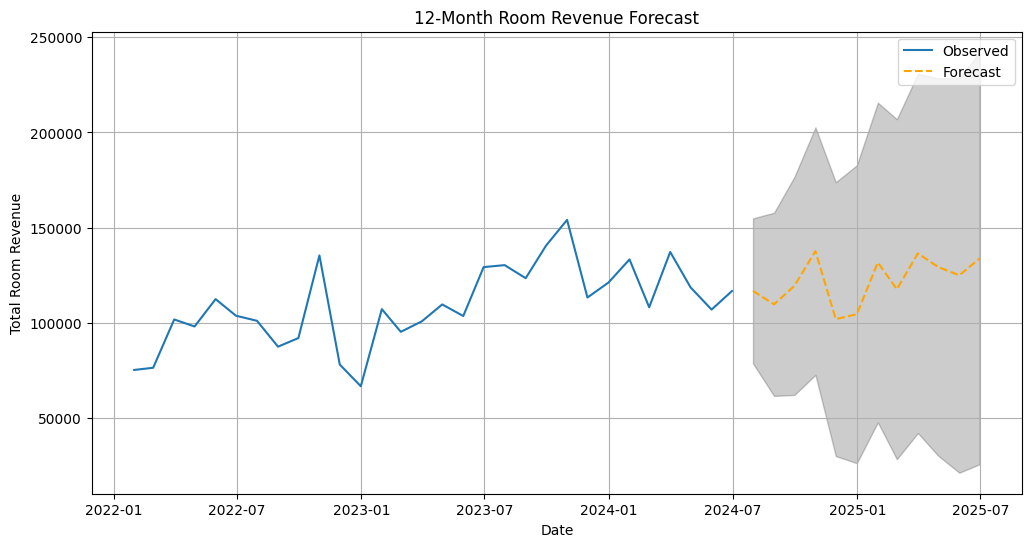

In [7]:
# Forecast the next 12 months
forecast_steps = 12  # Number of months to forecast
forecast = sarima_result.get_forecast(steps=forecast_steps)

# Create an index for the forecasted values
forecast_index = pd.date_range(monthly_revenue.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Extract forecasted values
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the observed data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange', linestyle='--')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.2)
plt.title('12-Month Room Revenue Forecast')
plt.xlabel('Date')
plt.ylabel('Total Room Revenue')
plt.legend()
plt.grid()
plt.show()
